# Prelude

In [1]:
import sys
import os

import matplotlib
import pandas
import numpy
import seaborn

from matplotlib import pyplot
from matplotlib.ticker import FuncFormatter

In [2]:
seaborn.set()

# Param Sweeps

In [3]:
pyplot.rcParams['figure.figsize'] = 3, 3

## Transformer

In [5]:
def to_pairs(df, name):
    df = df[df.columns[~df.columns.str.startswith('Step') & ~df.columns.str.endswith('MIN') & ~df.columns.str.endswith('MAX')]]
    df = df.iloc[-1]
    df = df.rename_axis('model').reset_index(name = name)
    df[['lr', 'varkappa']] = df.model.str.extract(r'sweep_([\d.]+)_([\d.]+)')
    return df.set_index(['lr', 'varkappa'])[name]

In [6]:
rouge1_f1 = pandas.read_csv('rouge1_f1_transformers.csv')
rouge2_f1 = pandas.read_csv('rouge2_f1_transformers.csv')
cs_loss = pandas.read_csv('cs_loss_transformers.csv')
combined = pandas.concat(
    [
        to_pairs(rouge1_f1, 'Rouge1_f1'),
        to_pairs(rouge2_f1, 'Rouge2_f1'),
        to_pairs(cs_loss, 'Cosine Similarity'),
    ],
    axis = 1,
)
combined

FileNotFoundError: [Errno 2] No such file or directory: 'rouge1_f1_transformers.csv'

In [15]:
def scatter(table, y_col, x_col):
    lrs = table.index.get_level_values('lr').unique()
    varkappas = table.index.get_level_values('varkappa').unique()

    lr_colors = dict(zip(lrs, seaborn.color_palette(None, 3)))
    markers = dict(zip(varkappas, ['o', 'P', '*']))

    for (lr, varkappa), data in table.iterrows():
        pyplot.scatter(
            data[x_col],
            data[y_col],
            color = lr_colors[lr],
            marker = markers[varkappa],
            s = 100,
            edgecolor = 'black',
            linewidth = 1,
            alpha = .80,
        )

    for lr in lrs:
        pyplot.scatter([], [], color = lr_colors[lr], label = fr'$\alpha = {lr}$', marker = 's', edgecolor = 'black', linewidth = 1, alpha = .8)

    for varkappa in varkappas:
        pyplot.scatter([], [], marker = markers[varkappa], label = fr'$\varkappa = {varkappa}$', color = 'gray', edgecolor = 'black', linewidth = 1, alpha = .8)

    pyplot.legend(fontsize = 'x-small', loc = 'lower right')

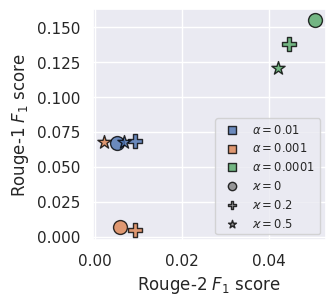

In [16]:
scatter(combined, 'Rouge1_f1', 'Rouge2_f1')
pyplot.ylabel('Rouge-1 $F_1$ score')
pyplot.xlabel('Rouge-2 $F_1$ score')

pyplot.savefig('../sweep_rouge1_v_rouge2.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

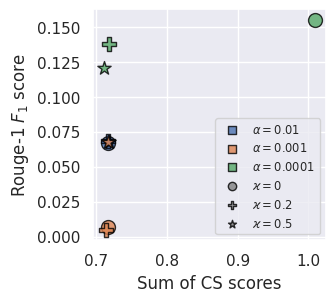

In [17]:
scatter(combined, 'Rouge1_f1', 'Cosine Similarity')
pyplot.ylabel('Rouge-1 $F_1$ score')
pyplot.xlabel('Sum of CS scores')

pyplot.savefig('../sweep_rouge1_v_cs.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

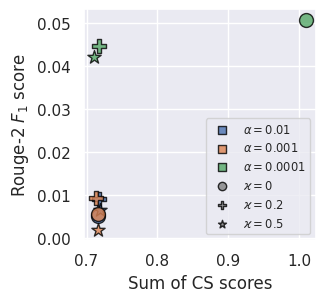

In [18]:
scatter(combined, 'Rouge2_f1', 'Cosine Similarity')
pyplot.ylabel('Rouge-2 $F_1$ score')
pyplot.xlabel('Sum of CS scores')

pyplot.savefig('../sweep_rouge2_v_cs.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [19]:
combined.sort_values('Rouge1_f1').iloc[-1]

Rouge1_f1            0.155120
Rouge2_f1            0.050723
Cosine Similarity    1.009277
Name: (0.0001, 0), dtype: float64

In [20]:
combined

Rouge1_f1  Rouge2_f1  Cosine Similarity
lr     varkappa                                         
0.01   0          0.066878   0.005060           0.716610
       0.2        0.068541   0.009143           0.717529
       0.5        0.067417   0.006515           0.718615
0.001  0          0.006819   0.005680           0.716820
       0.2        0.004879   0.009256           0.713443
       0.5        0.067849   0.001936           0.716634
0.0001 0          0.155120   0.050723           1.009277
       0.2        0.137581   0.044640           0.718023
       0.5        0.120372   0.042107           0.710801

## BERTFormer Sweep

In [7]:
def to_pairs(df):
    df = df[df.columns[~df.columns.str.startswith('Step') & ~df.columns.str.endswith('MIN') & ~df.columns.str.endswith('MAX')]]
    df = df.iloc[-1]
    df = df.rename_axis('metric').reset_index(name = 'value')
    df[['lr', 'varkappa']] = df.metric.str.extract(r'sweep_([\d.]+)_([\d.]+)')
    df.metric = df.metric.str.extract(r'(\w+)$')
    return df.pivot(columns = 'metric', index = ['lr', 'varkappa']).droplevel(0, axis = 1)

In [8]:
bertformers_sweep = to_pairs(pandas.read_csv('bertformers_sweep.csv'))

In [9]:
bertformers_sweep

metric            cs_loss  rouge1_f1  rouge2_f1
lr     varkappa                                
0.0001 0         1.016700   0.168643   0.063366
       0.2       0.707637   0.158728   0.060241
       0.5       0.699559   0.139646   0.050610
0.001  0.2       0.353111   0.073193   0.023410
       0.5       0.350980   0.070802   0.018526
0.01   0         0.507874   0.081411   0.021137
       0.2       0.358373   0.084601   0.030622
       0.5       0.347640   0.066484   0.024959

In [14]:
def scatter(table, y_col, x_col):
    lrs = table.index.get_level_values('lr').unique()
    varkappas = table.index.get_level_values('varkappa').unique()

    lr_colors = dict(zip(lrs[::-1], seaborn.color_palette(None, 3)))
    markers = dict(zip(varkappas, ['o', 'P', '*']))

    for (lr, varkappa), data in table.iterrows():
        pyplot.scatter(
            data[x_col],
            data[y_col],
            color = lr_colors[lr],
            marker = markers[varkappa],
            s = 100,
            edgecolor = 'black',
            linewidth = 1,
            alpha = .80,
        )

    for lr in lrs:
        pyplot.scatter([], [], color = lr_colors[lr], label = fr'$\alpha = {lr}$', marker = 's', edgecolor = 'black', linewidth = 1, alpha = .8)

    for varkappa in varkappas:
        pyplot.scatter([], [], marker = markers[varkappa], label = fr'$\varkappa = {varkappa}$', color = 'gray', edgecolor = 'black', linewidth = 1, alpha = .8)

    pyplot.legend(fontsize = 'x-small', loc = 'lower right')

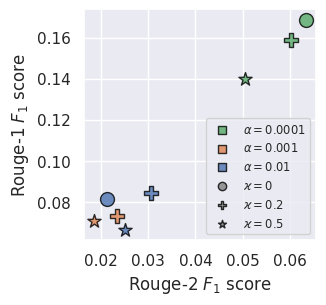

In [15]:
scatter(bertformers_sweep, 'rouge1_f1', 'rouge2_f1')
pyplot.ylabel('Rouge-1 $F_1$ score')
pyplot.xlabel('Rouge-2 $F_1$ score')

pyplot.savefig('../bertformer_sweep_rouge1_v_rouge2.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

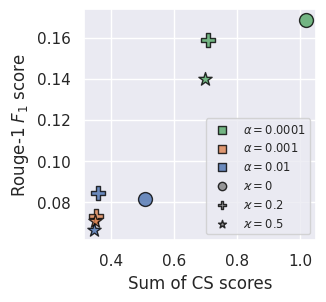

In [16]:
scatter(bertformers_sweep, 'rouge1_f1', 'cs_loss')
pyplot.ylabel('Rouge-1 $F_1$ score')
pyplot.xlabel('Sum of CS scores')

pyplot.savefig('../bertformer_sweep_rouge1_v_cs.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

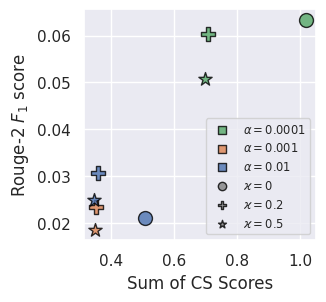

In [17]:
scatter(bertformers_sweep, 'rouge2_f1', 'cs_loss')
pyplot.ylabel('Rouge-2 $F_1$ score')
pyplot.xlabel('Sum of CS Scores')

pyplot.savefig('../bertformer_sweep_rouge2_v_cs.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

In [18]:
bertformers_sweep

metric            cs_loss  rouge1_f1  rouge2_f1
lr     varkappa                                
0.0001 0         1.016700   0.168643   0.063366
       0.2       0.707637   0.158728   0.060241
       0.5       0.699559   0.139646   0.050610
0.001  0.2       0.353111   0.073193   0.023410
       0.5       0.350980   0.070802   0.018526
0.01   0         0.507874   0.081411   0.021137
       0.2       0.358373   0.084601   0.030622
       0.5       0.347640   0.066484   0.024959

# Results

In [22]:
pyplot.rcParams['figure.figsize'] = 9, 2

## Seq2Seq

In [23]:
seq2seq = pandas.read_csv('seq2seq_results.csv')
seq2seq = seq2seq[seq2seq.columns[~seq2seq.columns.str.startswith('Step') & ~seq2seq.columns.str.endswith('MIN') & ~seq2seq.columns.str.endswith('MAX')]]
seq2seq = seq2seq.rename(lambda f: f.split(' ')[-1], axis = 1)
seq2seq.name = 'Seq2Seq'

In [24]:
seq2seq.head()

,train_loss,validation_loss,cs_loss,rouge1_f1,rouge2_f1
0,8.628492,9.020846,0,0.076246,0.002421
1,8.552739,8.922580,0,0.078200,0.002943
2,8.433880,8.943728,0,0.079828,0.002932
3,8.373028,8.893738,0,0.080158,0.002873
4,8.323572,8.882794,0,0.083208,0.003569


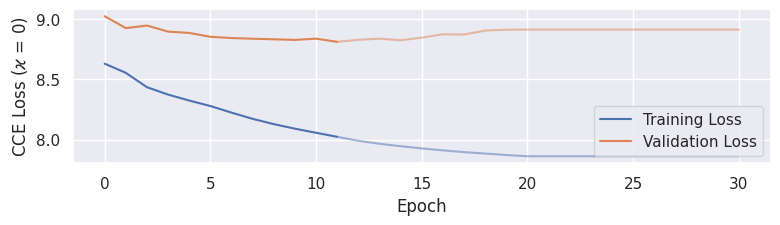

In [25]:
colors = seaborn.color_palette(None, 5)

valmin = seq2seq.validation_loss.argmin()

pyplot.plot(seq2seq.train_loss[:valmin + 1], label = 'Training Loss', color = colors[0])
pyplot.plot(seq2seq.train_loss[valmin:], alpha = .50, color = colors[0])
pyplot.plot(seq2seq.validation_loss[:valmin + 1], label = 'Validation Loss', color = colors[1])
pyplot.plot(seq2seq.validation_loss[valmin:], alpha = .50, color = colors[1])

pyplot.xlabel('Epoch')
pyplot.ylabel('CCE Loss ($\\varkappa$ = 0)')

pyplot.legend()

pyplot.savefig('../seq2seq_loss.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

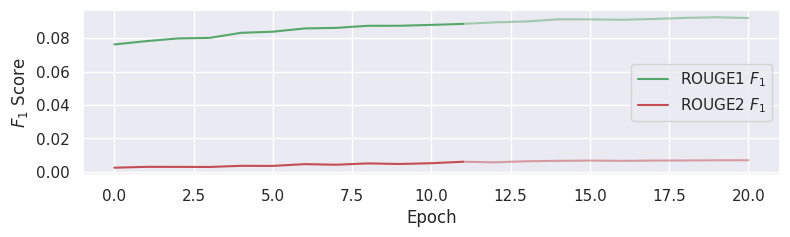

In [122]:
pyplot.plot(seq2seq.rouge1_f1[:valmin + 1], color = colors[2])
pyplot.plot(seq2seq.rouge1_f1[valmin:], alpha = .5, color = colors[2])

pyplot.plot(seq2seq.rouge2_f1[:valmin + 1], color = colors[3])
pyplot.plot(seq2seq.rouge2_f1[valmin:], alpha = .5, color = colors[3])

pyplot.plot([], label = 'ROUGE1 $F_1$', color = colors[2])
pyplot.plot([], label = 'ROUGE2 $F_1$', color = colors[3])

pyplot.xlabel('Epoch')
pyplot.ylabel('$F_1$ Score')

pyplot.legend()

pyplot.savefig('../seq2seq_rouge.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Transformer 

In [27]:
transformer = pandas.read_csv('transformer_results.csv')
transformer = transformer[transformer.columns[~transformer.columns.str.startswith('Step') & ~transformer.columns.str.endswith('MIN') & ~transformer.columns.str.endswith('MAX')]]
transformer = transformer.rename(lambda f: f.split(' ')[-1], axis = 1)
transformer.name = 'Transformer'

In [112]:
transformer.head()

,train_loss,validation_loss,cs_loss,rouge1_f1,rouge2_f1
0,8.945088,9.348183,2.307620,0.079986,0.004810
1,8.623701,9.229376,2.403248,0.087616,0.007296
2,8.416887,9.126234,2.406995,0.094624,0.009105
3,8.239845,9.026672,2.196303,0.097532,0.010104
4,8.082640,9.017926,2.316985,0.099517,0.011205


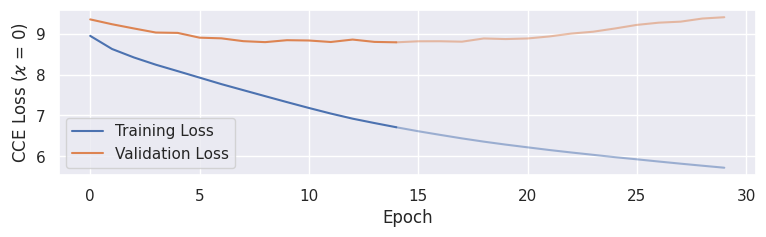

In [113]:
colors = seaborn.color_palette(None, 5)

valmin = transformer.validation_loss.argmin()

pyplot.plot(transformer.train_loss[:valmin + 1], label = 'Training Loss', color = colors[0])
pyplot.plot(transformer.train_loss[valmin:], alpha = .50, color = colors[0])
pyplot.plot(transformer.validation_loss[:valmin + 1], label = 'Validation Loss', color = colors[1])
pyplot.plot(transformer.validation_loss[valmin:], alpha = .50, color = colors[1])

pyplot.xlabel('Epoch')
pyplot.ylabel('CCE Loss ($\\varkappa$ = 0)')

pyplot.legend()

pyplot.savefig('../transformer_loss.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

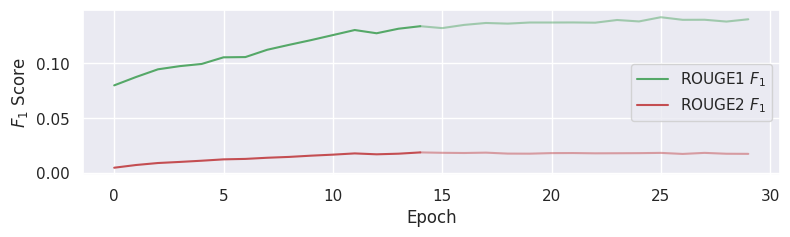

In [115]:
pyplot.plot(transformer.rouge1_f1[:valmin + 1], color = colors[2])
pyplot.plot(transformer.rouge1_f1[valmin:], alpha = .5, color = colors[2])

pyplot.plot(transformer.rouge2_f1[:valmin + 1], color = colors[3])
pyplot.plot(transformer.rouge2_f1[valmin:], alpha = .5, color = colors[3])

pyplot.plot([], label = 'ROUGE1 $F_1$', color = colors[2])
pyplot.plot([], label = 'ROUGE2 $F_1$', color = colors[3])

pyplot.xlabel('Epoch')
pyplot.ylabel('$F_1$ Score')

pyplot.legend()

pyplot.savefig('../transformer_rouge.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Combined

In [257]:
colors = seaborn.color_palette(None, 4)

In [321]:
def plot_losses(df, c):
    valmin = df.validation_loss.argmin()
    print(f'Best loss = {valmin}')

    pyplot.plot(df.train_loss[:valmin + 1], color = c, linestyle = '--')
    pyplot.plot(df.train_loss[valmin:], alpha = .50, color = c, linestyle = '--')
    pyplot.plot(df.validation_loss[:valmin + 1], color = c, markevery = [-1], marker = '|', markersize = 25)
    pyplot.plot(df.validation_loss[valmin:], alpha = .50, color = c)

    pyplot.plot([], color = c, label = f'{df.name} Val Loss')
    pyplot.plot([], color = c, linestyle = '--', label = f'Train Loss')

    pyplot.xlabel('Epoch')
    pyplot.ylabel('CCE Loss ($\\varkappa$ = 0)')

    pyplot.legend()

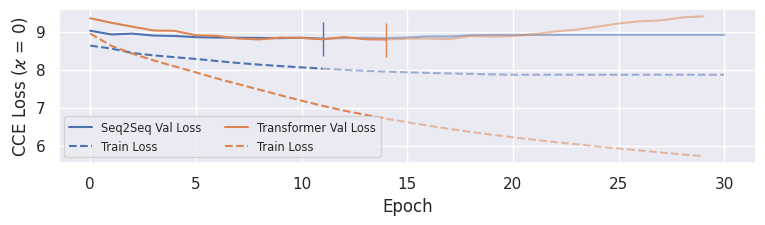

In [260]:
plot_losses(seq2seq, colors[0])
plot_losses(transformer, colors[1])
pyplot.savefig('../baseline_losses.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

In [313]:
colors = seaborn.color_palette(None, 12)

def plot_rouges(df, c, legend = False):
    valmin = df.validation_loss.argmin()
    print(f'Best loss = {valmin}')

    pyplot.plot(df.rouge1_f1[:valmin + 1], color = c[0])
    pyplot.plot(df.rouge1_f1[valmin:], alpha = .5, color = c[0])

    pyplot.plot(df.rouge2_f1[:valmin + 1], color = c[1])
    pyplot.plot(df.rouge2_f1[valmin:], alpha = .5, color = c[1])

    pyplot.xlabel('Epoch')
    pyplot.ylabel('$F_1$ Score')

    if legend:
        pyplot.plot([], label = f'{df.name} ROUGE1', color = c[0])
        pyplot.plot([], label = f'ROUGE2', color = c[1])
    
        pyplot.legend(
            # fontsize = 'x-small',
            # ncols = 2,
            loc = 0,
            # bbox_to_anchor = (1, .37),
        )

Best loss = 11
Best loss = 14


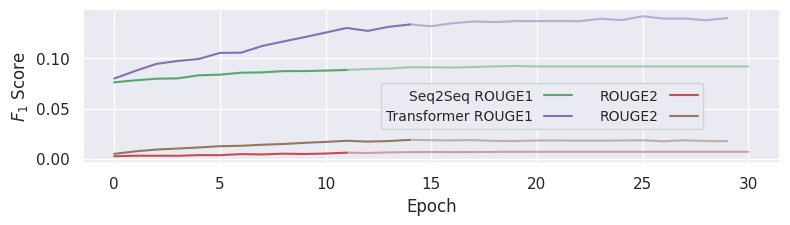

In [316]:
plot_rouges(seq2seq, colors[2:4])
plot_rouges(transformer, colors[4:6])

pyplot.plot([], label = 'Seq2Seq ROUGE1', color = colors[2])
pyplot.plot([], label = 'Transformer ROUGE1', color = colors[4])
pyplot.plot([], label = 'ROUGE2', color = colors[3])
pyplot.plot([], label = 'ROUGE2', color = colors[5])

pyplot.legend(
    ncols = 2,
    loc = 5,
    bbox_to_anchor = (0.9, .37),
    markerfirst = False,
    fontsize = 'small',
)

pyplot.savefig('../baseline_rouges.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

<Axes: >

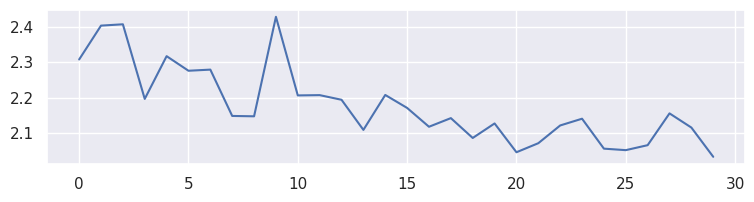

In [31]:
transformer.cs_loss.plot()

In [ ]:
colors = seaborn.color_palette(None, 12)

def plot_rouges(df, c, legend = False):
    valmin = df.validation_loss.argmin()
    print(f'Best loss = {valmin}')

    pyplot.plot(df.rouge1_f1[:valmin + 1], color = c[0])
    pyplot.plot(df.rouge1_f1[valmin:], alpha = .5, color = c[0])

    pyplot.plot(df.rouge2_f1[:valmin + 1], color = c[1])
    pyplot.plot(df.rouge2_f1[valmin:], alpha = .5, color = c[1])

    pyplot.xlabel('Epoch')
    pyplot.ylabel('$F_1$ Score')

    if legend:
        pyplot.plot([], label = f'{df.name} ROUGE1', color = c[0])
        pyplot.plot([], label = f'ROUGE2', color = c[1])
    
        pyplot.legend(
            # fontsize = 'x-small',
            # ncols = 2,
            loc = 0,
            # bbox_to_anchor = (1, .37),
        )

# Bertformer Things

In [33]:
bertformer = pandas.read_csv('bertformer_results.csv')
bertformer = bertformer[bertformer.columns[~bertformer.columns.str.startswith('Step') & ~bertformer.columns.str.endswith('MIN') & ~bertformer.columns.str.endswith('MAX')]]
bertformer = bertformer.rename(lambda f: f.split(' ')[-1], axis = 1)
bertformer.name = 'BERTFormer'

Best loss = 12


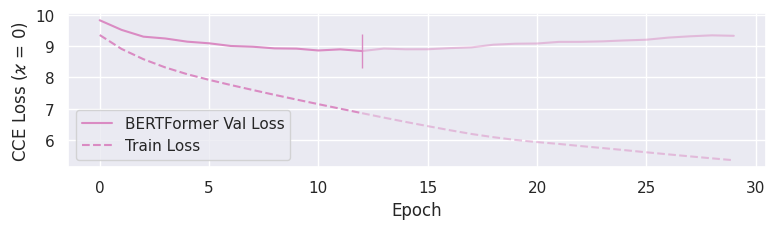

In [322]:
plot_losses(bertformer, colors[6])
pyplot.savefig('../bertformer_loss.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

Best loss = 12


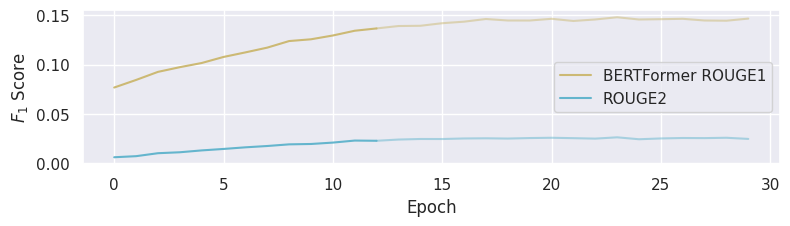

In [320]:
plot_rouges(bertformer, colors[8:], legend = True)
pyplot.savefig('../bertformer_rouge.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

## CS Scores

In [41]:
colors = seaborn.color_palette(None, 12)

In [47]:
colors

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)]

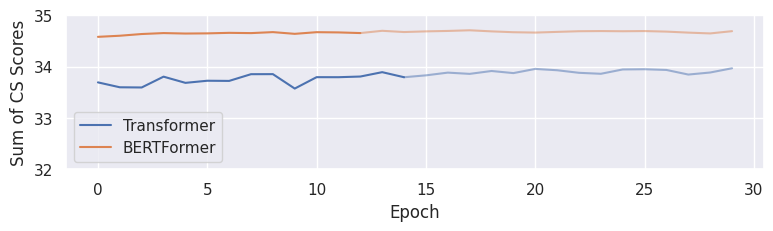

In [57]:
valmax_t = transformer.validation_loss.argmin()
valmax_b = bertformer.validation_loss.argmin()

a = ((1 - transformer / 36) * 36).cs_loss
b = ((1 - bertformer / 36) * 36).cs_loss

pyplot.plot(a[:valmax_t + 1], color = colors[10], label = 'Transformer')
pyplot.plot(a[valmax_t:], color = colors[10], alpha = .5)

pyplot.plot(b[:valmax_b + 1], color = colors[11], label = 'BERTFormer')
pyplot.plot(b[valmax_b:], color = colors[11], alpha = .5)

pyplot.xlabel('Epoch')
pyplot.ylabel('Sum of CS Scores')

pyplot.ylim(32, 35)

pyplot.legend()

pyplot.savefig('../cs_scores.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)

In [60]:
a[valmax_t]

33.792562634198696

In [61]:
b[valmax_t]

34.67292924101377

# Results

In [326]:
seq2seq.loc[seq2seq.validation_loss.argmin()]

train_loss         8.023741
validation_loss    8.809007
cs_loss            0.000000
rouge1_f1          0.088554
rouge2_f1          0.006011
Name: 11, dtype: float64

In [327]:
transformer.loc[transformer.validation_loss.argmin()]

train_loss         6.709476
validation_loss    8.787388
cs_loss            2.207437
rouge1_f1          0.133974
rouge2_f1          0.018791
Name: 14, dtype: float64

In [328]:
bertformer.loc[bertformer.validation_loss.argmin()]

train_loss         6.855993
validation_loss    8.846433
cs_loss            1.346995
rouge1_f1          0.136657
rouge2_f1          0.022685
Name: 12, dtype: float64